# Dataset Preparation
Notebook for creating dictionaries, train, test, and validation sets for the proposed method, using the beats extracted from the MIT-BIH dataset.

To-Do:

**✅ Load the beats for each user.**

**✅ Make sure each beat is detrended and normalized.**

**✅ Create a dictionary for each patient from its 5 minute data.**

**✅ Save the dictionaries.**

**✅ Find the annihilator matrix of each dictionary.**

**✅ For patient p, prepare p's dataset by getting other patients' healthy and arrhythmia beats. Healthy beats must be <= arrhythmia beats.**

**✅ For patient p, also save the patient id's where each beat comes from, shuffle the datasets, and do train/validation splits.**

**✅ Save the datasets.**

## Imports

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import io as sio
from scipy import signal as sps
from scipy import linalg as spl
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
from os.path import join as osj
from bisect import bisect
from collections import defaultdict 
import pickle
import json

from progress_bar import print_progress

# 01 Read beat data sets
Set the path to the beats extracted in step 1.

- DICT = 5 minute mark
- DATA = remaining beats

Adjust the variable trio as needed

In [2]:
trio = False

if trio:
    DATA_ROOT = osj("..", "data_trio")
else:
    DATA_ROOT = osj("..", "data_single")

DICT_BEATS = osj(DATA_ROOT, "dataset_beats", "5min_normal_beats.pkl")
DATA_BEATS = osj(DATA_ROOT, "dataset_beats", "25min_beats.pkl")

In [3]:
def read_dict_beats():
    with open(DICT_BEATS, "rb") as f:
        return pickle.load(f)
    
def read_data_beats():
    with open(DATA_BEATS, "rb") as f:
        return pickle.load(f)
    
def ensure_normalized_and_detrended(beats):
    for key in beats.keys():
        b = beats[key]["beats"]
        if not np.allclose(np.linalg.norm(b, axis=1, ord=2), 1):
            raise AssertionError(f"Beats of patient {key} is not normalized.")
            
        p = np.polyfit(np.arange(b.shape[1]), b.T, deg=1)
        if not np.allclose(p, 0):
            raise AssertionError(f"Beats of patient {key} is not detrended.")

**Solves the Lasso problem:**
$$ \underset{\vec{x}}{\arg\min} \left[\dfrac{1}{2}\|\mathbf{A}\vec{x} - \vec{b}\|_2^2 + \lambda\|\vec{x}\|_1 \right] $$

**using [Alternating Direction Method of Multipliers](https://statweb.stanford.edu/~candes/teaching/math301/Lectures/Consensus.pdf). In our case, this corresponds to:**
$$ \underset{\mathbf{\vec{x}}}{\arg\min} \left[\|\mathbf{D\vec{x} - \vec{s}}\|_2^2 + \lambda\|\mathbf{\vec{x}}\|_1 \right] $$

**where $\mathbf{D}$ is the dictionary matrix, $\mathbf{\vec{x}}$ is the keys, and $\mathbf{\vec{s}}$ is the signal represented using $\mathbf{D}\vec{x}$. We can also represent an entire dataset of signals as $\mathbf{D}\mathbf{X} = \mathbf{S}$.**

In [4]:
def generate_dictionary(S, num_atoms=20, delta_err=None, max_it=100, max_admm=100, calc_err=False, seed=0, printing=False):
    """
    Generate a dictionary that represents the signals given in S ∈ (N x F) with sparse keys, minimizing the Lasso loss.
    D ∈ (F x num_atoms).
    X ∈ (num_atoms x N).
    
    Parameters
    ----------
    S : array_like
        Signals to be represented. S ∈ (N x F).
    num_atoms : int
        Number of dictionary elements.
    delta_err : float, default=None
        Stopping criteria for change in error. Stops if the decrease in error is less than (current error * delta_err): 
            Stops if: err(t-1) - err(t) < err(t-1) * delta_err
        Note: calc_err must be true. If calc_err is False, max_it is used. If max_it is reached, we stop regardless.
    """
    assert delta_err is None or calc_err, "Early stopping is not possible without error calculations."  # delta_err implies calc_err
        
    np.random.seed(seed)
    S = S.T  # S ∈ (F x N)
    D = np.random.randn(S.shape[0], num_atoms)
    D = D / np.linalg.norm(D, axis=0, ord=2)
    k = 0
    if calc_err:
        E = np.zeros(max_it)
    
    while k < max_it:
        X = lasso_solver_ADMM(D, S, max_it=max_admm)
        D = S @ np.linalg.pinv(X)  # DX = S  ->  DXX+ = SX+  ->  D = SX+            (Y @ S') \ (S @ S')
        D = D / np.linalg.norm(D, axis=0, ord=2)
        
        if calc_err:
            err = np.linalg.norm((D @ X) - S, ord=2, axis=None)
            E[k] = err
            if k > 1 and delta_err is not None and np.abs(E[k - 1] - E[k]) < E[k - 1] * delta_err:
                if printing:
                    print_progress(k + 1, max_it, add_newline=True)
                    print(f"Stopping early. Abs error diff: {np.abs(E[k - 1] - E[k]):.2e}, Threshold: {E[k - 1] * delta_err:.2e}")
                k = k + 1
                return D, X, E[:k]
            
        k = k + 1
        if printing:
            print_progress(k, max_it)
        
    if calc_err:
        return D, X, E
    return D, X

def lasso_solver_ADMM(A, b, max_it=100):
    x = np.zeros((A.shape[1], b.shape[1]))
    z = np.zeros_like(x)
    y = np.zeros_like(x)
    AtA = A.T @ A
    I = np.eye(AtA.shape[0])
    Atb = A.T @ b
    tau_ = 0.08  # one over tau
    lambda_tau = 0.01 / tau_  # lambda * tau
    k = 0
    
    while k < max_it:
        x = np.linalg.solve(AtA + tau_ * I, Atb + tau_ * (z - y))
        z = soft_threshold(x + y, lambda_tau)
        y = y + tau_ * (x - z)
        k = k + 1
        
    return x

def soft_threshold(x, lambda_):
    """
    Implements:
        x - lambda    if x > lambda
        x + lambda    if x < -lambda
        0             otherwise (x in [-lambda, lambda])
    """
    return np.maximum(0, x - lambda_) - np.maximum(0, -lambda_ - x)

In [ ]:
dict_beats = read_dict_beats() # reads 5min beats
data_beats = read_data_beats() # reads 25min beats

ensure_normalized_and_detrended(dict_beats)
ensure_normalized_and_detrended(data_beats)

patient_ids = pd.read_csv(osj("..", "files", "patient_ids.csv"), header=None).to_numpy().reshape(-1)
paced_patients = pd.read_csv(osj("..", "files", "paced_patients.csv"), header=None).to_numpy().reshape(-1)
excluded_patients = pd.read_csv(osj("..", "files", "excluded_patients.csv"), header=None).to_numpy().reshape(-1)

In [5]:
paced_patients

array([102, 104, 107, 217])

In [3]:
excluded_patients

array([105, 114, 201, 202, 207, 209, 213, 222, 223, 234])

# 02 Generate the dictionary for each patient

- **Seed=patient_id is used when generating dictionaries to be reproducable.**
- **Additionally, the dictionaries are now sorted based on the occurrence of keys of the beats creating it.**
- set "save" to True if the data should be stored

In [6]:
%%time
Ds = {}
save = False

if trio:
    DICT_PATH = osj(DATA_ROOT, "dictionaries", "5min_sorted")
else:
    DICT_PATH = osj(DATA_ROOT, "dictionaries", "5min_sorted")



for i, patient_id in enumerate(patient_ids):
    if patient_id in paced_patients or patient_id in excluded_patients:
        continue
        
    dict_beat = dict_beats[patient_id]["beats"]
    D, X, E = generate_dictionary(dict_beat, num_atoms=20, delta_err=None, max_it=20, max_admm=100, calc_err=True, seed=patient_id, printing=True)
    
    # sort D in decreasing order, based on the l1-norm of X's rows.
    sortidx = np.argsort(np.abs(X).sum(axis=1))[::-1]
    D = D[:, sortidx]
    X = X[sortidx, :]
    
    F = spl.null_space(D.T)
    F = spl.orth(F).T
    
    Ds[patient_id] = D
    
    if save:
        with open(osj(DICT_PATH, f"patient_{patient_id}_dictionary.pkl"), "wb") as f:
            pickle.dump(D, f)

    print_progress(i + 1, len(patient_ids))

20/20 [====================]
CPU times: user 2min 58s, sys: 8min 2s, total: 11min 1s
Wall time: 13.8 s


# 03 Visualize dictionary

In [7]:
def visualize_dictionary(D):
    plt.figure(figsize=(10, 10))
    for i in range(D.shape[1]):
        plt.plot(D[:, i] + 20 - i)
    plt.show()

def visualize_keys(X):
    plt.figure(figsize=(15, 10))
    sns.heatmap(X, cmap="gray")
    plt.show()

def visualize_fit(D, X, beats):
    plt.plot(D @ X, "C0", alpha=0.02)
    plt.plot(beats, "C1", alpha=0.02)
    plt.show()
    return np.linalg.norm((D @ X - beats), ord=2, axis=None)

In [8]:
D.shape, X.shape, F.shape

((128, 20), (20, 385), (108, 128))

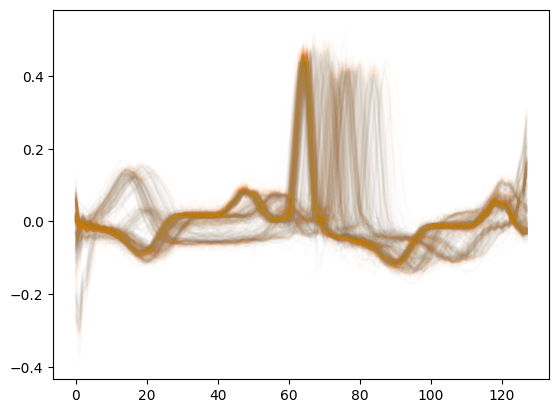

0.5887997402031527

In [9]:
visualize_fit(D, X, dict_beat.T) # Example for single beat

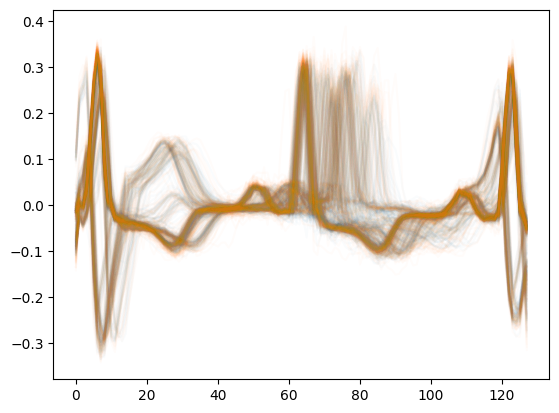

0.6519981938795769

In [ ]:
visualize_fit(D, X, dict_beat.T) # Example for beat trio

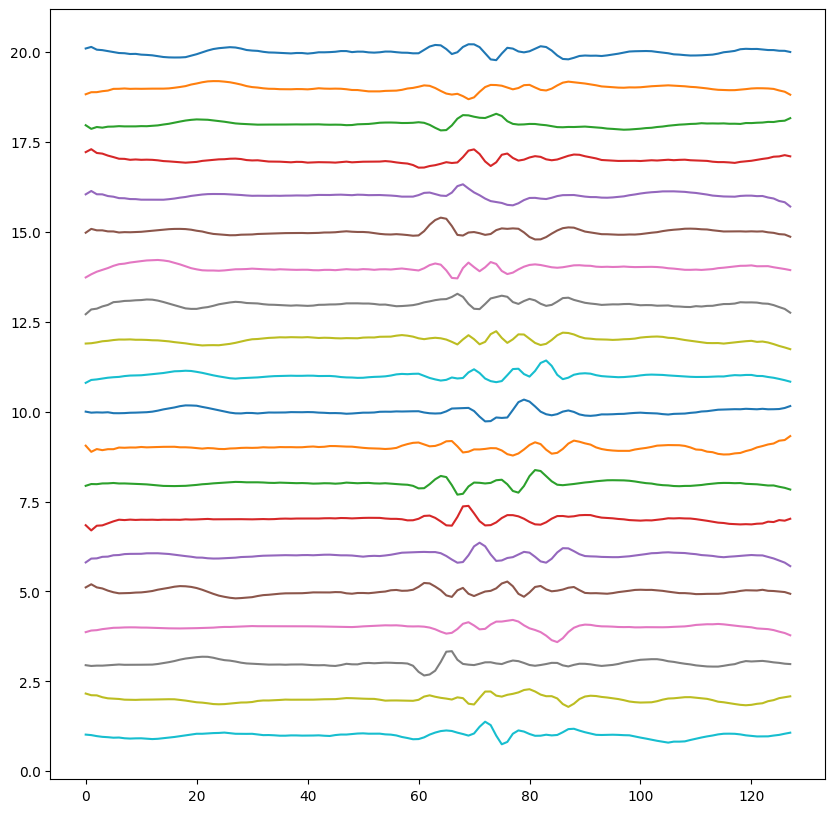

In [10]:
visualize_dictionary(D) # Example for single beat

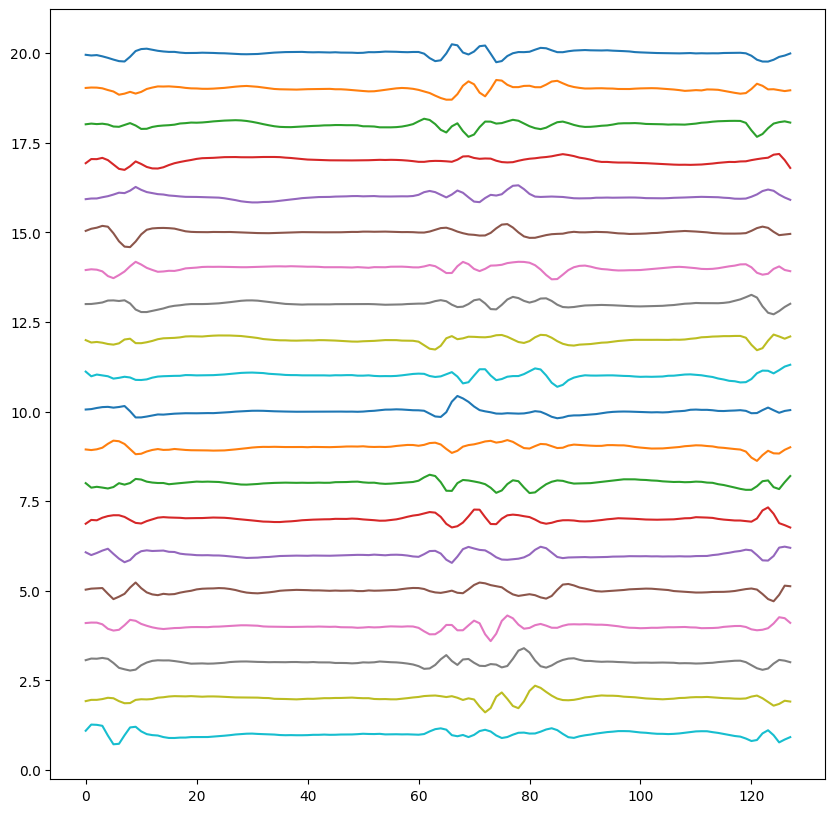

In [ ]:
visualize_dictionary(D) # Example for beat trio

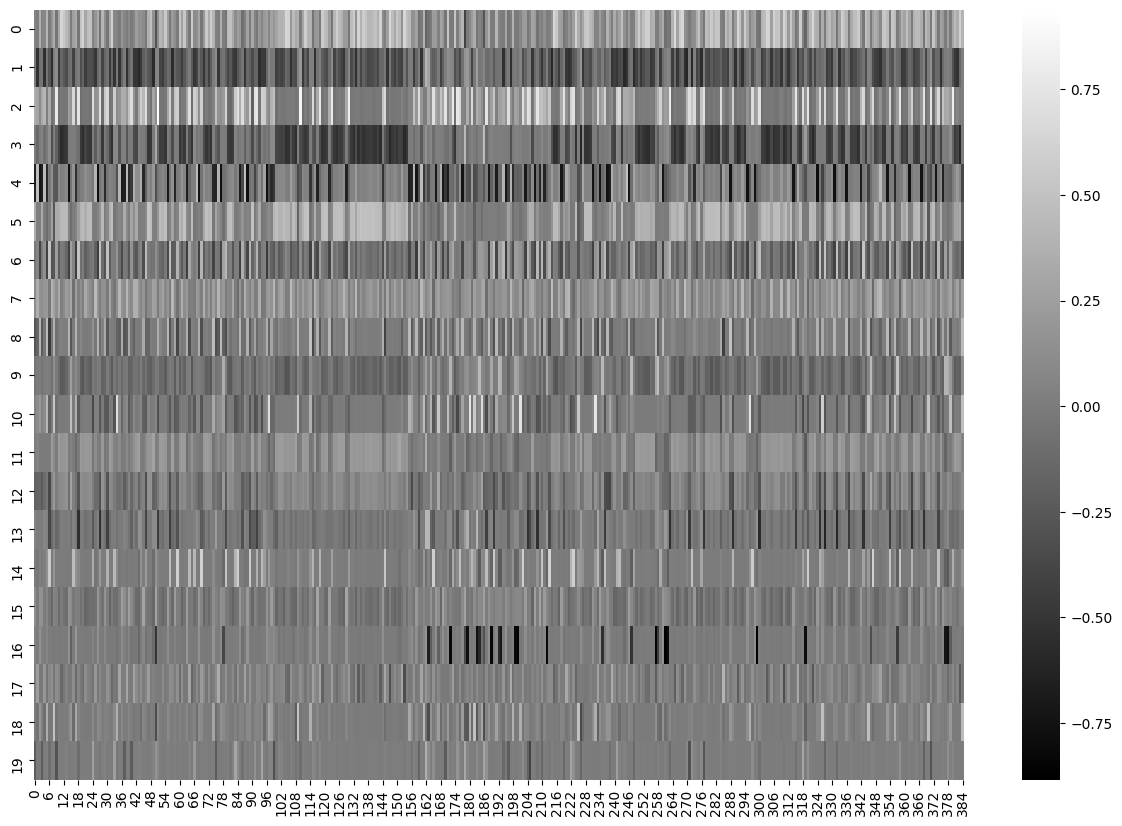

In [11]:
visualize_keys(X) # Example for single beat

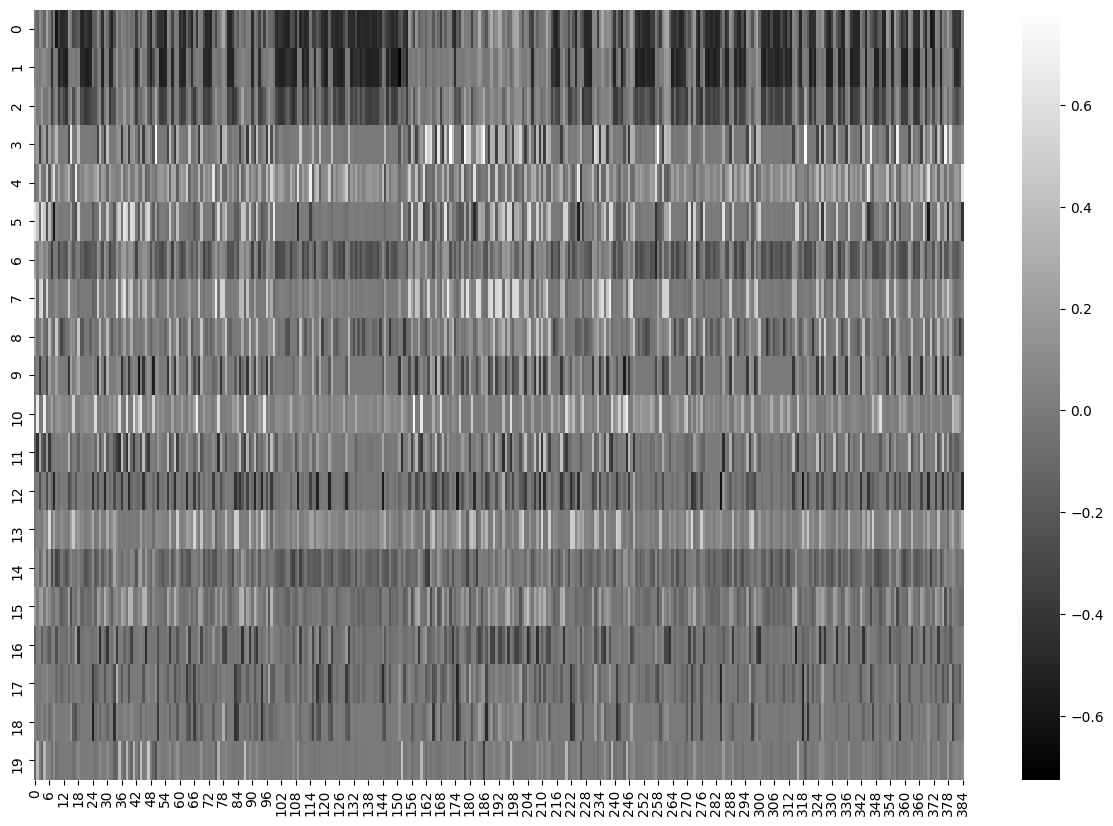

In [ ]:
visualize_keys(X) # Example for beat trio

# 04 Domain Adaptation Functions
Domain Adaptation from one patient to another. <br> Problem: Given two patients, modify the beats of one patient to improve its beat representation on another patient's dictionary.

\begin{equation}
\begin{aligned}
\hat{Q}, \hat{C}_j &= \underset{Q,\,C_j}{\arg\min} \, J \\
J &=  \|QX_j - D_iC_j\|_2^2 + \|C_j\|_1 + \gamma\|X_j - QX_j\|_2^2 \\
\dfrac{\partial J}{\partial Q} &= 2\left( QX_j - D_iC_j \right)X_j^T - 2\gamma\left( X_j - Q_jX_j \right)X_j^T \\
  &= Q_jX_jX_j^T - D_iC_jX_j^T - \gamma X_jX_j^T + \gamma Q_jX_jX_j^T = 0 \\
Q &= \left( D_iC_jX_j^T + \gamma X_jX_j^T \right) \left( X_jX_j^T + \gamma X_jX_j^T \right)^{-1}
\end{aligned}
\end{equation}

<br> where $Q$ is the matrix that transforms $X_j$ to another domain so that it is better represented with $D_i$.

In [15]:
class DomainAdapter():
    def __init__(self):
        self.adapted = False
    
    def adapt(self, Di, Sj, gamma: int, max_it: int=100, max_admm: int=100, plot=False):
        Q = np.eye(Di.shape[0])
        Sj = Sj.T
        
        # Save for speedup
        SjSjT = Sj @ Sj.T
        gSjSjT = gamma * SjSjT

        if plot:
            plt.figure()
        for i in range(max_it):
            QSj = Q @ Sj
            if plot:
                plt.plot(QSj[:, 0], label=f"iter={i}")
            QSj = QSj / np.linalg.norm(QSj, axis=0, ord=2)
            Cj = lasso_solver_ADMM(Di, QSj, max_it=max_admm)
            Q = (Di @ Cj @ Sj.T + gSjSjT) @ np.linalg.pinv(SjSjT + gSjSjT)
            
        if plot:
            plt.legend()
            plt.show()

        self.Q = Q
        self.adapted = True
        return Q
    
    def adapt_gd(self, Di, Sj, gamma: int, lr: float=0.01, max_epochs: int=100, max_admm: int=100, plot=False):
        Q = np.eye(Di.shape[0])
        Sj = Sj.T

        # Save for speedup
        SjSjT = Sj @ Sj.T
        gSjSjT = gamma * SjSjT

        if plot:
            plt.figure()
        for i in range(max_epochs):
            QSj = Q @ Sj
            if plot and i % 10 == 0:
                plt.plot(QSj[:, 0], label=f"iter={i}")
            QSj = QSj / np.linalg.norm(QSj, axis=0, ord=2)
            Cj = lasso_solver_ADMM(Di, QSj, max_it=max_admm)
            
            grad_Q = Q @ SjSjT - Di @ Cj @ Sj.T - gSjSjT + gamma * Q @ SjSjT
            Q = Q - lr * grad_Q
        
        if plot:
            plt.legend()
            plt.show()
        
        self.Q = Q
        self.adapted = True
        return Q
    
    def test(self, Di, Si_D, Si_T, yi, Sj_D, Sj_T, yj, Q, max_it: int=100):
        assert self.adapted, "Call adapt first."
        
        # Fit of i's dictionary beats.
        Ci_D = lasso_solver_ADMM(Di, Si_D.T, max_it=max_it)
        Ei_D = np.linalg.norm((Di @ Ci_D) - Si_D.T, ord=2, axis=0).mean()
        
        # Fit of i's train/test beats.
        Ci_T = lasso_solver_ADMM(Di, Si_T.T, max_it=max_it)
        Ei_T = np.linalg.norm((Di @ Ci_T) - Si_T.T, ord=2, axis=0)
        Ei_T_healthy = Ei_T[yi == "N"].mean()
        Ei_T_arrhyth = Ei_T[yi != "N"].mean()
        
        # Fit of j's dictionary beats on i's dictionary.
        Cj_D = lasso_solver_ADMM(Di, Sj_D.T, max_it=max_it)
        Ej_D = np.linalg.norm((Di @ Cj_D) - Sj_D.T, ord=2, axis=0).mean()
        
        # Fit of j's train/test beats on i's dictionary.
        Cj_T = lasso_solver_ADMM(Di, Sj_T.T, max_it=max_it)
        Ej_T = np.linalg.norm((Di @ Cj_T) - Sj_T.T, ord=2, axis=0)
        Ej_T_healthy = Ej_T[yj == "N"].mean()
        Ej_T_arrhyth = Ej_T[yj != "N"].mean()
        
        # Fit of j's dictionary beats on i's dictionary after domain adaptation.
        QSj_D = Q @ Sj_D.T
        QSj_D = QSj_D / np.linalg.norm(QSj_D, axis=0, ord=2)
        
        DA_Cj_D = lasso_solver_ADMM(Di, QSj_D, max_it=max_it)
        DA_Ej_D = np.linalg.norm((Di @ DA_Cj_D) - QSj_D, ord=2, axis=0).mean()
        
        # Fit of j's train/test beats on i's dictionary after domain adaptation.
        QSj_T = Q @ Sj_T.T
        QSj_T = QSj_T / np.linalg.norm(QSj_T, axis=0, ord=2)
        
        DA_Cj_T = lasso_solver_ADMM(Di, QSj_T, max_it=max_it)
        DA_Ej_T = np.linalg.norm((Di @ DA_Cj_T) - QSj_T, ord=2, axis=0)
        DA_Ej_T_healthy = DA_Ej_T[yj == "N"].mean()
        DA_Ej_T_arrhyth = DA_Ej_T[yj != "N"].mean()
        
        d = {
            "Ei_D": Ei_D, "Ei_T_healthy": Ei_T_healthy, "Ei_T_arrhyth": Ei_T_arrhyth,
            "Ej_D": Ej_D, "Ej_T_healthy": Ej_T_healthy, "Ej_T_arrhyth": Ej_T_arrhyth,
            "DA_Ej_D": DA_Ej_D, "DA_Ej_T_healthy": DA_Ej_T_healthy, "DA_Ej_T_arrhyth": DA_Ej_T_arrhyth
        }
        
        return d

In [16]:
def get_patient_adaptation_matrix(i, j, gamma, lr, max_epochs):
    DA = DomainAdapter()
    Q = DA.adapt_gd(Ds[i], dict_beats[j]["beats"], gamma=gamma, lr=lr, max_epochs=max_epochs)
    return Q

# 05 Generate the train, test, and validation data.

In [ ]:
def get_patient_beat_class_counts():
    """
    Finds the number of healthy and arrhythmia beats for each patient.
    """
    healthies = []
    arrhythmias = []
    for i, patient_id in enumerate(patient_ids):
        data_beat = data_beats[patient_id]["beats"]
        data_class = data_beats[patient_id]["class"]
        num_healthy = np.count_nonzero(data_class == "N")
        num_arrhyth = np.count_nonzero(data_class != "N")
        healthies.append(num_healthy)
        arrhythmias.append(num_arrhyth)
    # to store the counts of healthy and arrhythmia beats for each patient
    # pd.DataFrame(data=[patient_ids, healthies, arrhythmias], index=["patient_id", "num_healthy", "num_arrhythmia"]).T.to_csv("patient_beat_class_counts.csv", index=False)
    return np.array(healthies), np.array(arrhythmias)

In [18]:
def get_patient_healthy_and_arrhythmia(patient_id, healthy_leq_arrhyth=True):
    """
    Returns healthy and arrhythmia beats of patient, where number of healthy returned <= number of arrhythmia returned.
    """
    data_beat = data_beats[patient_id]["beats"]
    data_class = data_beats[patient_id]["class"]
    idx_healthy = np.where(data_class == "N")[0]
    idx_arrhyth = np.where(data_class != "N")[0]
    num_healthy = len(idx_healthy)
    num_arrhyth = len(idx_arrhyth)
    
    if healthy_leq_arrhyth and num_healthy > num_arrhyth:
        num_healthy = num_arrhyth  # take only as much as arrhythmias, maybe try to take all healthies?
    
    healthies = data_beat[idx_healthy[:num_healthy], ...]
    arrhythmias = data_beat[idx_arrhyth[:num_arrhyth], ...]
    return healthies, arrhythmias

In [19]:
def get_patient_train_data(patient_id):
    """
    For patient p, prepare p's train data by getting other patients' healthy and arrhythmia beats + p's dictionary beats. 
    Healthy beats must be <= arrhythmia beats.
    """
    train_X = []
    train_y = []
    train_ids = []
    for i, other_id in enumerate(patient_ids):
        if other_id == patient_id or other_id in paced_patients or other_id in excluded_patients:
            continue
        other_healthy, other_arrhyth = get_patient_healthy_and_arrhythmia(other_id)
        
        Q = get_patient_adaptation_matrix(patient_id, other_id, gamma=0.2, lr=0.002, max_epochs=25)
        other_healthy = (Q @ other_healthy.T)
        other_healthy = other_healthy / np.linalg.norm(other_healthy, axis=0, ord=2)
        other_healthy = other_healthy.T
        
        other_arrhyth = (Q @ other_arrhyth.T)
        other_arrhyth = other_arrhyth / np.linalg.norm(other_arrhyth, axis=0, ord=2)
        other_arrhyth = other_arrhyth.T
        
        train_X.append(other_healthy)
        train_y.append(np.zeros(len(other_healthy)))
        train_X.append(other_arrhyth)
        train_y.append(np.ones(len(other_arrhyth)))
        train_ids.append(np.ones(len(other_healthy) + len(other_arrhyth)) * other_id)
    dict_beat = dict_beats[patient_id]["beats"]
    train_X.append(dict_beat)
    train_y.append(np.zeros(len(dict_beat)))
    train_ids.append(np.ones(len(dict_beat)) * patient_id)
    
    return np.concatenate(train_X, axis=0), np.concatenate(train_y, axis=0), np.concatenate(train_ids, axis=0)

In [20]:
def get_patient_test_data(patient_id):
    """
    For patient p, prepare p's test data from p's 25 minute beats (i.e. beats that are not dictionary beats).
    """
    data_beat = data_beats[patient_id]["beats"]
    data_class = data_beats[patient_id]["class"]
    idx_healthy = np.where(data_class == "N")[0]
    idx_arrhyth = np.where(data_class != "N")[0]
    
    test_X = [data_beat[idx_healthy], data_beat[idx_arrhyth]]
    test_y = [np.zeros(len(idx_healthy)), np.ones(len(idx_arrhyth))]
    test_ids = np.ones(len(idx_healthy) + len(idx_arrhyth)) * patient_id
    
    return np.concatenate(test_X, axis=0), np.concatenate(test_y, axis=0), test_ids

In [21]:
def shuffle(X, y, ids, seed=None):
    """
    Shuffle X, y and ids with the same indices, and optionally set a seed.
    """
    if seed is not None:
        np.random.seed(seed)
    shuffle_idx = np.random.permutation(len(y))
    return X[shuffle_idx], y[shuffle_idx], ids[shuffle_idx]

In [ ]:
def train_validation_split(train_X, train_y, train_ids, ratio):
    """
    Train/Validation split by the given ratio, where ratio is size_train / size_all. Keeps the ratio of healthy and arrhythmia beats the same in train and
    validation sets.
    """
    idx_healthy = np.where(train_y == 0)[0]
    idx_arrhyth = np.where(train_y == 1)[0]
    
    num_healthy = len(idx_healthy)
    num_arrhyth = len(idx_arrhyth)
    
    num_train_healthy = int(num_healthy * ratio)
    num_train_arrhyth = int(num_arrhyth * ratio)
    
    num_val_healthy = num_healthy - num_train_healthy
    num_val_arrhyth = num_arrhyth - num_train_arrhyth
    
    val_X = np.concatenate((train_X[idx_healthy[0:num_val_healthy]], train_X[idx_arrhyth[0:num_val_arrhyth]]))
    val_y = np.concatenate((train_y[idx_healthy[0:num_val_healthy]], train_y[idx_arrhyth[0:num_val_arrhyth]]))
    val_ids = np.concatenate((train_ids[idx_healthy[0:num_val_healthy]], train_ids[idx_arrhyth[0:num_val_arrhyth]]))
    
    train_X = np.concatenate((train_X[idx_healthy[num_val_healthy:]], train_X[idx_arrhyth[num_val_arrhyth:]]))
    train_y = np.concatenate((train_y[idx_healthy[num_val_healthy:]], train_y[idx_arrhyth[num_val_arrhyth:]]))
    train_ids = np.concatenate((train_ids[idx_healthy[num_val_healthy:]], train_ids[idx_arrhyth[num_val_arrhyth:]])) 
    
    return train_X, train_y, train_ids, val_X, val_y, val_ids

In [ ]:
def generate_patient_datasets():
    """
    Combines all of the functions above to generate datasets for each patient.
    """
    for i, patient_id in enumerate(patient_ids):
        if patient_id in paced_patients or patient_id in excluded_patients:
            continue
        train_X, train_y, train_ids = get_patient_train_data(patient_id)
        train_X, train_y, train_ids = shuffle(train_X, train_y, train_ids, seed=patient_id)
        
        test_X, test_y, test_ids = get_patient_test_data(patient_id)
        test_X, test_y, test_ids = shuffle(test_X, test_y, test_ids, seed=None)
        
        train_X, train_y, train_ids, val_X, val_y, val_ids = train_validation_split(train_X, train_y, train_ids, ratio=0.8)
        train_X, train_y, train_ids = shuffle(train_X, train_y, train_ids, seed=None)
        val_X, val_y, val_ids = shuffle(val_X, val_y, val_ids, seed=None)
        
        with open(osj(DATASET_PATH, f"patient_{patient_id}_dataset.pkl"), "wb") as f:
            pickle.dump(
                {
                    "train_X": train_X,
                    "train_y": train_y,
                    "train_ids": train_ids,
                    "val_X": val_X,
                    "val_y": val_y,
                    "val_ids": val_ids,
                    "test_X": test_X,
                    "test_y": test_y,
                    "test_ids": test_ids
                },
                f
            )
        print_progress(i + 1, len(patient_ids))

In [ ]:
if trio:
    DATASET_PATH = osj("..", "data_trio", "dataset_training", "domain_adapted")
else:
    DATASET_PATH = osj("..", "data_single", "dataset_training", "domain_adapted")

In [50]:
%%time

generate_patient_datasets() # Takes around 5 minutes to generate all datasets.

CPU times: user 1h 3min 45s, sys: 2h 51min 22s, total: 3h 55min 7s
Wall time: 4min 55s


run this script twice: for single beats and trio beats